In [1]:
from hapiclient import hapi, hapitime2datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
from geopack import geopack
import datetime as datetime

Load IGRF coefficients ...


In [2]:
def fetch_omni_data(params,data, start, stop):
    server      = 'https://cdaweb.gsfc.nasa.gov/hapi'
    dataset     = data
    parameters  = params
    data, meta  = hapi(server, dataset, parameters, start, stop)

    return data

In [3]:
def extract_data(data, params):

    header = params.split(',')
    header.insert(0, 'Timestamp')

    #extract the data from the list
    extracted_data = [[x[i] for x in data] for i in range(len(header))]

    #create a dictionary and convert to dataframe using param names as headers
    df_dict = {header: values for header, values in zip(header, extracted_data)}
    df = pd.DataFrame(df_dict).set_index('Timestamp')

    #convert to datetime from '\b' time
    df.index = hapitime2datetime(df.index.values.astype(str))
    df.index = df.index.tz_convert("UTC").tz_convert(None)


    return df

In [4]:
def extract_omni_1min(data, params):

    df = extract_data(data, params)
    df['Timestamp_1min_omni'] = df.index
    df['Timestamp_1hr_omni'] = pd.to_datetime(df['Timestamp_1min_omni'], errors='coerce').dt.floor('1h')
    df = df.reset_index(drop=True)
    
    return df


In [5]:
def extract_omni_1hr(params, data):

    df = extract_data(data, params)

    df['Timestamp_1hr_omni'] = df.index
    df['Timestamp_1hr_omni'] = pd.to_datetime(df['Timestamp_1hr_omni'], errors='coerce').dt.floor('1h')

    df = df.reset_index(drop=True)
    
    return df

In [6]:
omni_1min = "OMNI_HRO_1MIN"
omni_1min_params = 'percent_interp,BY_GSE,BZ_GSE,flow_speed,proton_density,T,Pressure,E,Mach_num,BSN_x,BSN_y,BSN_z,SYM_H'

omni_1hr = "OMNI2_H0_MRG1HR"
omni_1hr_params = 'F10_INDEX1800,KP1800'

#Pressure = flow pressure in nPa

yr = 2021
months = []
years = [2021,2022]
for year in years:
    for month in range(1,13):

        print('Processing: ',year, month)

        _, num_days = calendar.monthrange(year, month)

        start_time = f'{year}-{month:02d}-{1:02d}T00:00:000Z'
        end_time = f'{year}-{month:02d}-{num_days:02d}T23:59:59Z'

        #download the data then clean it
        omni_1min_data = fetch_omni_data(omni_1min_params, omni_1min, start_time, end_time)
        omni_1min_df = extract_omni_1min(omni_1min_data, omni_1min_params)

        omni_1hr_data = fetch_omni_data(omni_1hr_params,omni_1hr, start_time, end_time)
        omni_1hr_df = extract_omni_1hr(omni_1hr_params, omni_1hr_data)

        df = pd.merge(omni_1min_df, omni_1hr_df, on='Timestamp_1hr_omni', how='left')
        df = df.rename(columns={'F10_INDEX1800':'F10.7', 'KP1800':'Kp'})
        months.append(df)
        
months_df = pd.concat(months)
months_df = months_df.reset_index(drop=True)

#export_path = f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/data/omni/' #macbook
#export_path = f'/home/ryuho/Documents/reddy/research/SMRAI/Data/OMNI/' #linux
export_path = f'/home/sachin/Documents/NIPR/Research/VSCode/REPPU-ESN2/SR_ML/' #server

df_name = f'omni_hro_1min_2021-2022'
export_filename = export_path + df_name +'.csv'
months_df.to_csv(export_filename, index=False, header=True)
months_df
        

Processing:  2021 1


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2021 2


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2021 3


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2021 4


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2021 5


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2021 6


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2021 7


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2021 8


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2021 9


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2021 10


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2021 11


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2021 12


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2022 1


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2022 2


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2022 3


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2022 4


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2022 5


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2022 6


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2022 7


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2022 8


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2022 9


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2022 10


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2022 11


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


Processing:  2022 12


/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()
/home/sachin/miniconda3/envs/server_env/lib/python3.12/site-packages/hapiclient/hapitime.py:287: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  Time = pandas.to_datetime(Time, infer_datetime_format=True).tz_convert(tzinfo).to_pydatetime()


,percent_interp,BY_GSE,BZ_GSE,flow_speed,proton_density,T,Pressure,E,Mach_num,BSN_x,BSN_y,BSN_z,SYM_H,Timestamp_1min_omni,Timestamp_1hr_omni,F10.7,Kp
0,0,0.86,0.65,360.100006,4.34,33250.0,1.13,999.99,13.4,14.40,-1.79,0.64,-3,2021-01-01 00:00:00,2021-01-01 00:00:00,77.699997,0
1,0,0.64,0.87,360.100006,4.34,33250.0,1.13,-0.36,13.4,14.42,-1.76,0.58,-3,2021-01-01 00:01:00,2021-01-01 00:00:00,77.699997,0
2,0,0.85,0.76,358.000000,4.24,37818.0,1.09,-0.34,13.2,14.42,-1.60,0.43,-2,2021-01-01 00:02:00,2021-01-01 00:00:00,77.699997,0
3,0,0.71,0.89,358.100006,4.70,34037.0,1.21,-0.37,13.3,14.30,-1.61,0.45,-2,2021-01-01 00:03:00,2021-01-01 00:00:00,77.699997,0
4,0,-0.17,1.47,358.100006,4.93,31957.0,1.26,-0.49,13.6,14.36,-1.60,0.47,-1,2021-01-01 00:04:00,2021-01-01 00:00:00,77.699997,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051195,100,3.11,-0.03,569.599976,2.67,86049.0,1.73,-0.42,8.4,13.49,-0.64,0.58,-23,2022-12-31 23:55:00,2022-12-31 23:00:00,159.500000,40
1051196,55,3.47,-0.89,573.900024,2.48,77893.0,1.63,0.01,8.1,13.37,-0.63,0.18,-23,2022-12-31 23:56:00,2022-12-31 23:00:00,159.500000,40
1051197,78,3.93,-0.51,586.299988,2.64,90625.0,1.81,-0.28,8.5,13.37,-0.54,0.21,-23,2022-12-31 23:57:00,2022-12-31 23:00:00,159.500000,40
1051198,78,2.61,-0.91,563.299988,2.12,54870.0,1.35,0.14,7.3,13.49,-0.86,0.16,-23,2022-12-31 23:58:00,2022-12-31 23:00:00,159.500000,40


In [56]:
#import_path=r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/data/omni/omni_hro_5min_2021-2022.csv'
import_path = r'omni_hro_1min_2021-2022.csv'
omni_df = pd.read_csv(import_path)
omni_df

,percent_interp,BY_GSE,BZ_GSE,flow_speed,proton_density,T,Pressure,E,Mach_num,BSN_x,BSN_y,BSN_z,SYM_H,Timestamp_1min_omni,Timestamp_1hr_omni,F10.7,Kp
0,0,0.86,0.65,360.100006,4.34,33250.0,1.13,999.99,13.4,14.40,-1.79,0.64,-3,2021-01-01 00:00:00,2021-01-01 00:00:00,77.699997,0
1,0,0.64,0.87,360.100006,4.34,33250.0,1.13,-0.36,13.4,14.42,-1.76,0.58,-3,2021-01-01 00:01:00,2021-01-01 00:00:00,77.699997,0
2,0,0.85,0.76,358.000000,4.24,37818.0,1.09,-0.34,13.2,14.42,-1.60,0.43,-2,2021-01-01 00:02:00,2021-01-01 00:00:00,77.699997,0
3,0,0.71,0.89,358.100006,4.70,34037.0,1.21,-0.37,13.3,14.30,-1.61,0.45,-2,2021-01-01 00:03:00,2021-01-01 00:00:00,77.699997,0
4,0,-0.17,1.47,358.100006,4.93,31957.0,1.26,-0.49,13.6,14.36,-1.60,0.47,-1,2021-01-01 00:04:00,2021-01-01 00:00:00,77.699997,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051195,100,3.11,-0.03,569.599976,2.67,86049.0,1.73,-0.42,8.4,13.49,-0.64,0.58,-23,2022-12-31 23:55:00,2022-12-31 23:00:00,159.500000,40
1051196,55,3.47,-0.89,573.900024,2.48,77893.0,1.63,0.01,8.1,13.37,-0.63,0.18,-23,2022-12-31 23:56:00,2022-12-31 23:00:00,159.500000,40
1051197,78,3.93,-0.51,586.299988,2.64,90625.0,1.81,-0.28,8.5,13.37,-0.54,0.21,-23,2022-12-31 23:57:00,2022-12-31 23:00:00,159.500000,40
1051198,78,2.61,-0.91,563.299988,2.12,54870.0,1.35,0.14,7.3,13.49,-0.86,0.16,-23,2022-12-31 23:58:00,2022-12-31 23:00:00,159.500000,40


In [57]:
def clean_omni(df):
    df = df.copy()
    df = df.dropna()

    #filters
    df = df[df['BY_GSE'] < 100]
    df = df[df['BZ_GSE'] < 100]
    df = df[df['flow_speed'] < 1400]
    df = df[df['proton_density'] < 150]
    df = df[df['T'] < 1e6]
    df = df[df['Pressure'] < 100]
    df = df[df['E'] < 100]
    df = df[df['Mach_num'] < 100]
    df = df[df['SYM_H'].between(-1000,100)]
    df = df[df['F10.7'] < 400]
    df = df[df['Kp'] < 100]
    df['Kp'] = df['Kp'] / 10

    #change data types
    df[['F10.7','flow_speed']] = df[['F10.7','flow_speed']].astype(int)

    #new features
    df['Timestamp_1min_omni'] = pd.to_datetime(df['Timestamp_1min_omni'])
    df['doy'] = df['Timestamp_1min_omni'].dt.dayofyear
    
    def calculate_tilt_angle(row):
        t0 = datetime.datetime(1970, 1, 1)
        t1 = row['Timestamp_1min_omni']
        tdiff = (t1 - t0).total_seconds()
        tilt_angle = geopack.recalc(tdiff) # Calculate dipole tilt angle
        
        return tilt_angle
    
    df['tilt_angle'] = df.apply(calculate_tilt_angle, axis=1)

    #interpolate missing values
    df = df.interpolate()
    df = df.drop(columns=['percent_interp','Timestamp_1hr_omni','BSN_y','BSN_z'])

    #match SMRAI2 inputs
    #df = df.drop(columns=['BSN_x','SYM_H','doy','T','Pressure','E','Mach_num','SYM_H','F10.7','Kp'])
    return df

omni_df = clean_omni(omni_df)
omni_df

/tmp/ipykernel_36578/450412232.py:37: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()


,BY_GSE,BZ_GSE,flow_speed,proton_density,T,Pressure,E,Mach_num,BSN_x,SYM_H,Timestamp_1min_omni,F10.7,Kp,doy,tilt_angle
1,0.64,0.87,360,4.34,33250.0,1.13,-0.36,13.4,14.42,-3,2021-01-01 00:01:00,77,0.0,1,-0.442911
2,0.85,0.76,358,4.24,37818.0,1.09,-0.34,13.2,14.42,-2,2021-01-01 00:02:00,77,0.0,1,-0.443602
3,0.71,0.89,358,4.70,34037.0,1.21,-0.37,13.3,14.30,-2,2021-01-01 00:03:00,77,0.0,1,-0.444293
4,-0.17,1.47,358,4.93,31957.0,1.26,-0.49,13.6,14.36,-1,2021-01-01 00:04:00,77,0.0,1,-0.444982
5,0.68,1.24,358,4.22,32921.0,1.09,-0.49,12.1,14.50,-1,2021-01-01 00:05:00,77,0.0,1,-0.445671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051195,3.11,-0.03,569,2.67,86049.0,1.73,-0.42,8.4,13.49,-23,2022-12-31 23:55:00,159,4.0,365,-0.439291
1051196,3.47,-0.89,573,2.48,77893.0,1.63,0.01,8.1,13.37,-23,2022-12-31 23:56:00,159,4.0,365,-0.439978
1051197,3.93,-0.51,586,2.64,90625.0,1.81,-0.28,8.5,13.37,-23,2022-12-31 23:57:00,159,4.0,365,-0.440665
1051198,2.61,-0.91,563,2.12,54870.0,1.35,0.14,7.3,13.49,-23,2022-12-31 23:58:00,159,4.0,365,-0.441351


In [63]:
#show nan values


In [59]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])

time = np.arange(288) #24hrs in 5min intervals
dt = [] 
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5)) #add 5min intervals to each day
dt = np.array(dt) #convert from list to numpy array
mhd_dates = pd.DataFrame({'Timestamp_1min_omni': dt}) 
mhd_dates

,Timestamp_1min_omni
0,2021-05-10 00:00:00
1,2021-05-10 00:05:00
2,2021-05-10 00:10:00
3,2021-05-10 00:15:00
4,2021-05-10 00:20:00
...,...
45787,2022-07-31 23:35:00
45788,2022-07-31 23:40:00
45789,2022-07-31 23:45:00
45790,2022-07-31 23:50:00


In [60]:
omni_mhd_dt_merged = pd.merge(mhd_dates, omni_df, on='Timestamp_1min_omni', how='left')
omni_mhd_dt_merged.rename(columns={'Timestamp_1min_omni':'dt'}, inplace=True)
omni_mhd_dt_merged.sort_values(by='dt', inplace=True)
#omni_mhd_dt_merged =omni_mhd_dt_merged.interpolate()
#check for nan values
omni_mhd_dt_merged.isnull().sum()

dt                    0
BY_GSE            11601
BZ_GSE            11601
flow_speed        11601
proton_density    11601
T                 11601
Pressure          11601
E                 11601
Mach_num          11601
BSN_x             11601
SYM_H             11601
F10.7             11601
Kp                11601
doy               11601
tilt_angle        11601
dtype: int64

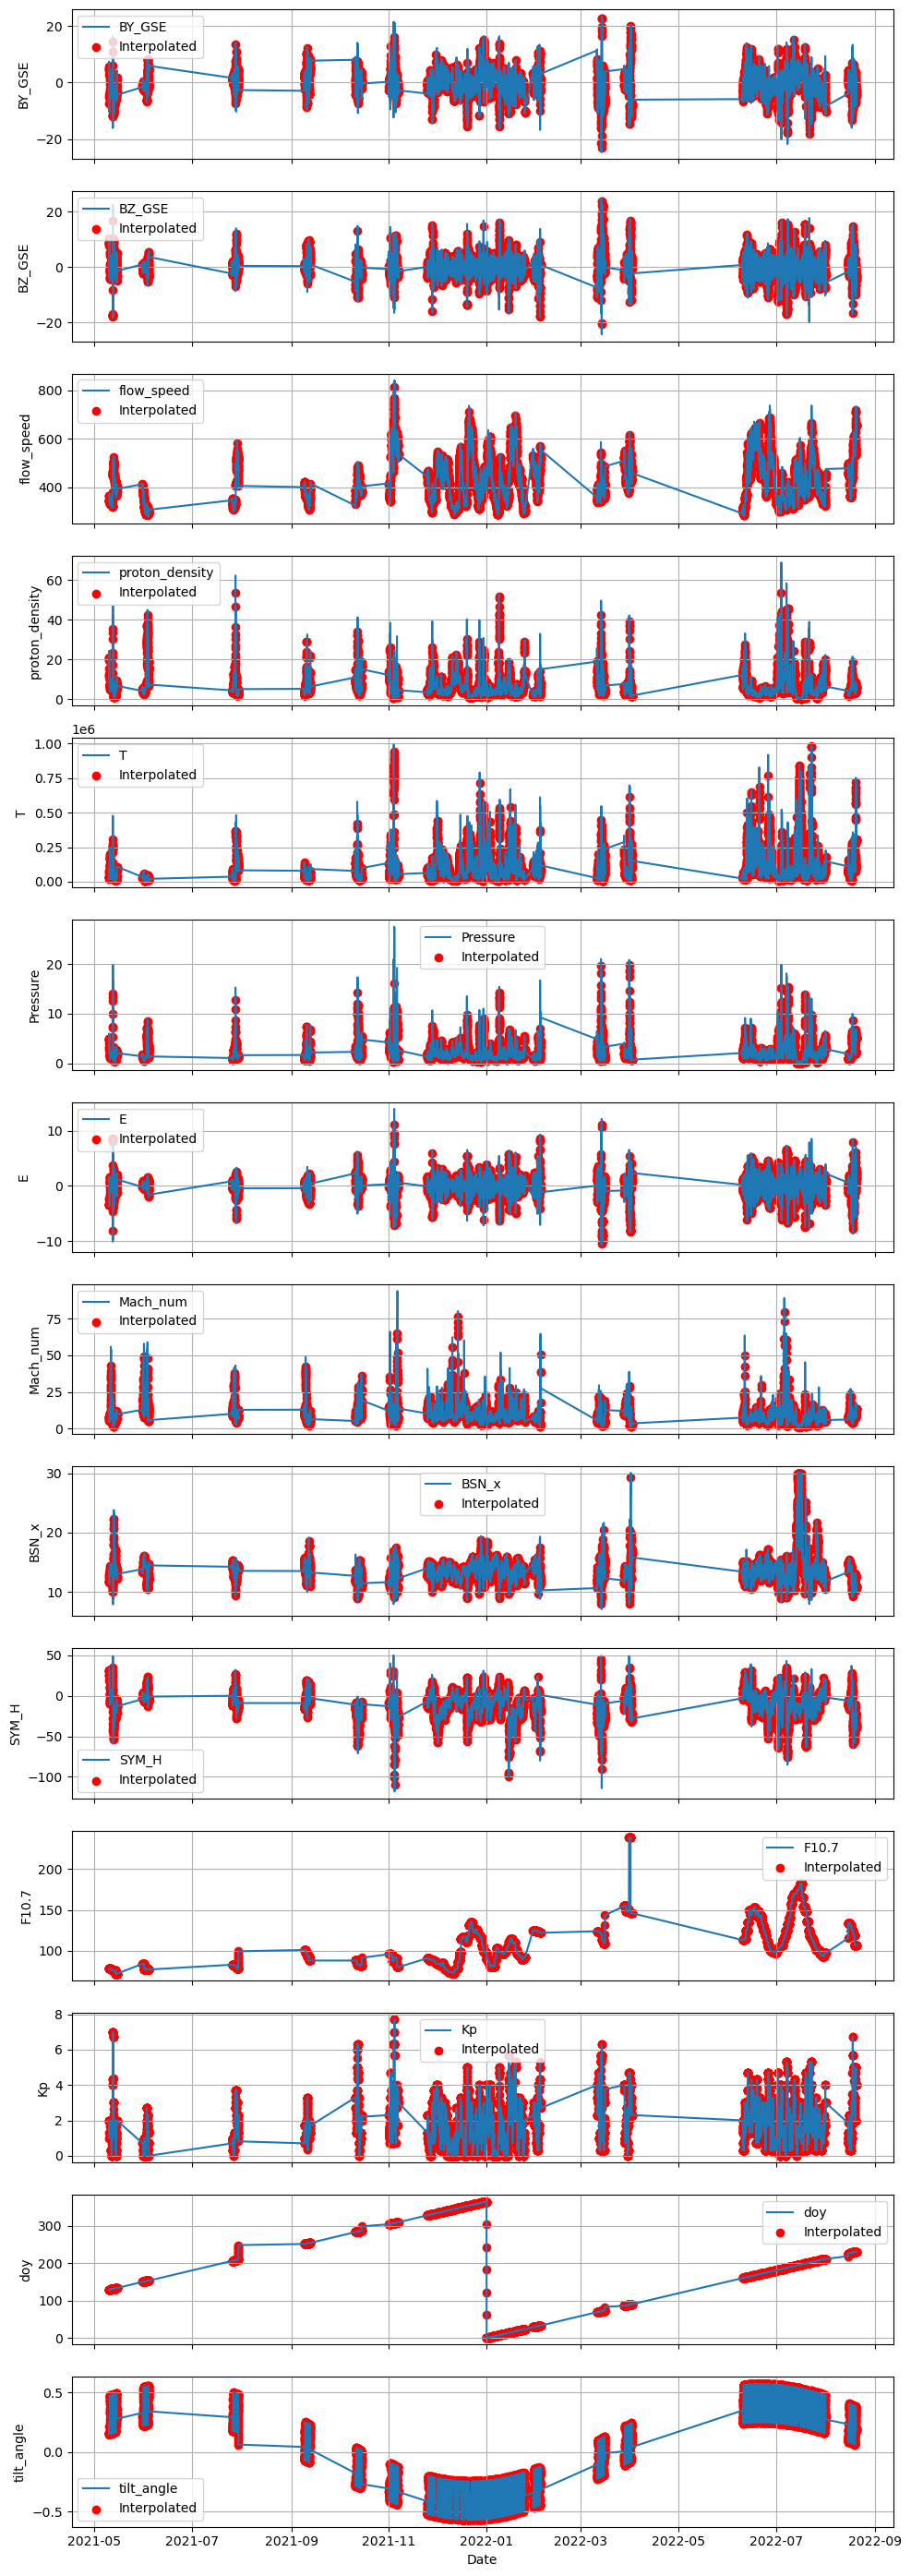

In [40]:
# Merge the dataframes
omni_mhd_dt_merged = pd.merge(mhd_dates, omni_df, on='Timestamp_1min_omni', how='left')
omni_mhd_dt_merged.rename(columns={'Timestamp_1min_omni': 'dt'}, inplace=True)
omni_mhd_dt_merged.sort_values(by='dt', inplace=True)

# Interpolate missing values
omni_mhd_dt_merged['interpolated'] = omni_mhd_dt_merged.isnull().any(axis=1).astype(int)
omni_mhd_dt_merged = omni_mhd_dt_merged.interpolate()

# Plotting
fig, axes = plt.subplots(nrows=len(omni_mhd_dt_merged.columns[1:-1]), ncols=1, figsize=(10, 2 * len(omni_mhd_dt_merged.columns[1:-1])), sharex=True)
for i, column in enumerate(omni_mhd_dt_merged.columns[1:-1]):
    axes[i].plot(omni_mhd_dt_merged['dt'], omni_mhd_dt_merged[column], label=column)
    axes[i].scatter(omni_mhd_dt_merged['dt'][omni_mhd_dt_merged['interpolated'] == 1], omni_mhd_dt_merged[column][omni_mhd_dt_merged['interpolated'] == 1], color='red', label='Interpolated')
    axes[i].set_ylabel(column)
    axes[i].legend()
    axes[i].grid(True)
plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [61]:
#export omni_mhd_dt_merged
#export_path = f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/data/omni/'
#export_path = f'/home/sachin/Documents/NIPR/Research/VSCode/REPPU-ESN2/SR_ML/'
df_name = f'omni_add-feats_mhd_5min'
#export_filename = export_path + df_name +'.csv'
export_filename = df_name +'.csv'
omni_mhd_dt_merged.to_csv(export_filename, index=False, header=True)


In [ ]:
#show nan values
nan_values = omni_mhd_dt_merged[omni_mhd_dt_merged.isna().any(axis=1)]
nan_values.sort_values(by='dt')

Plots are below. Not part of main code

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
omni_df.hist(ax=ax)
plt.tight_layout()

In [ ]:
y = omni_df['doy']
x = omni_df['tilt_angle']
r2 = x.corr(y)
sns.jointplot(x=x, y=y, kind='scatter', s=1, height=4.5)
RE = r'R$_E$'
pcc = r'cm$^{-3}$'
#plt.xlabel(f'Proton Density [{pcc}]')
#plt.ylabel(f'Bow Shock Nose Location (GSE-X) [{RE}]')
#plt.xlabel('Pressure [nPa]')

#plt.ylabel('Electric Field [mV/m]')
#plt.xlabel('Bz [nT]')

r2_lab = r'R$^2$'    
annotation = f'{r2_lab} = {r2:.2f}'
plt.annotate(annotation, xy=(0.75, 0.7), xycoords='axes fraction', fontsize=11)
plt.tight_layout()
plt.savefig('/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Analysis/Apr-24/plots/omni/R2_tilt-angle_doy.png', dpi=300)

In [ ]:
corr = omni_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7.5, 6.5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7}, annot=True,
             fmt=".2f")

plt.title('OMNI 5min Data Correlation Matrix \n January 2021 - December 2022',pad=-40)
plt.tight_layout()
#plt.savefig('/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Analysis/Apr-24/plots/omni/omni_heatmap.png', dpi=400)

In [ ]:
sns.histplot(omni_mhd_dt_merged['flow_speed'], bins=50)
omni_mhd_dt_merged['flow_speed'].describe()

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(omni_df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt=".2f")